In [ ]:
# ls /dev/tty.*

In [ ]:
# %pip install matplotlib
# %pip install ipywidgets
# %pip install telemetrix
# %pip install pyfirmata

In [4]:
%pip install firebase-admin

  Using cached cachecontrol-0.14.3-py3-none-any.whl.metadata (3.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached msgpack-1.1.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached cffi-1.17.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (1.5 kB)
  Using cached charset_normalizer-3.4.2-cp310-cp310-macosx_10_9_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
Using cached cachecontrol-0.14.3-py3-none-any.whl (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 46.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 36.5 M

In [ ]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import pickle
import time
import ipywidgets as widgets
from IPython.display import display
import sys
from telemetrix import telemetrix

DIGITAL_B = 11 # the board LED
DIGITAL_G = 12
DIGITAL_R = 7
SERVO_PIN = 5
BUTTON_PIN = 10
# BUZZER = 13

WAIT_TIME = 2 # sleep time to keep forever loop open

# callback data indices
CB_PIN_MODE = 0
CB_PIN = 1
CB_VALUE = 2
CB_TIME = 3
flag = True

def the_callback(data):
    global flag
    value = data[CB_VALUE]
    if value == 0:
        print('System Reset')
        board.digital_write(DIGITAL_B, 1)
        board.digital_write(DIGITAL_R, 0)
        flag = False
    time.sleep(WAIT_TIME)

board = telemetrix.Telemetrix('/dev/tty.usbmodem1101', arduino_wait=6)
board.digital_write(DIGITAL_B, 1)

# taking a picture with your webcam
# board.digital_write(BUZZER, 0)

# first we create a camera object
camera = cv2.VideoCapture(0)

# now we take 2 pictures since the first pic tends to be too dark,
# as the code runs too fast for the exposure to be enough
for i in range(3):
    success, img_captured = camera.read()
    time.sleep(0.3) # waiting time for the webcam to get more light

cv2.imwrite('capturedPicture.png', img_captured) # saving the second pic we took
del camera # closes the access to the camera by closing the camera object

# Enter the paths for your image and cascade files here

imagePath = 'capturedPicture.png'
labelsPath = 'labels.pickle'

# Create the haar cascade (XML file that contains the data to detect faces)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Face classifier

# create the recognizer
recognizer = cv2.face.LBPHFaceRecognizer_create()
# import the training data for the recognizer
recognizer.read("trainer.yml")

# import the lables created by the facesTrain program
label = {}
with open("labels.pickle", "rb") as pickleFile:
    original_labels = pickle.load(pickleFile)
    # invert the order:
    labels = {v:k for k, v in original_labels.items()}

# read the image
image = cv2.imread(imagePath)
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title("Original Image")
plt.imshow(image_RGB) # open the image as RGB
plt.xticks([]), plt.yticks([])
plt.show()

# transform the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.title("Gray Image")
plt.imshow(gray, cmap='gray') # open the image as greyscale
plt.xticks([]), plt.yticks([])
plt.show()

# detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.21,
    minNeighbors=4,
    minSize=(20,20),
    flags = cv2.CASCADE_SCALE_IMAGE
)
print(faces)

# print "Found {0} faces!".format(len(faces))
print('Faces found: ', len(faces))

# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(image_RGB, (x, y), (x+w, y+h), (0, 255, 0), 5)
    roi_gray = gray[y:y+h, x:x+w]
    id_now, confidence = recognizer.predict(roi_gray)
    print("confidence = ", confidence)
    print("Face Recognized")
    print("Access Granted")
plt.title("Faces Found")
plt.imshow(image_RGB) # open the image as RGB
plt.xticks([]), plt.yticks([])
plt.show()

if confidence >= 70 and len(faces) > 0:
    board.digital_write(DIGITAL_B, 0)
    board.digital_write(DIGITAL_G, 1)
    board.set_pin_mode_servo(SERVO_PIN, 100, 3000)
    time.sleep(0.2)
    board.servo_write(SERVO_PIN, 180)
    time.sleep(1)
    board.servo_write(SERVO_PIN, 0)
    print("Opening the secret exit")
else:
    # board.digital_write(DIGITAL_B, 0)
    # board.digital_write(DIGITAL_R, 1)
    board.set_pin_mode_digital_input_pullup(BUTTON_PIN, callback = the_callback)
    print("Access Denied")
    print("Security Breach")
    while (flag):
        # board.digital_write(BUZZER, 1)
        board.digital_write(DIGITAL_R, 1)
        time.sleep(0.5)
        # board.digital_write(BUZZER, 0)
        board.digital_write(DIGITAL_R, 0)
        time.sleep(0.5)

board.shutdown()


Telemetrix:  Version 1.43

Copyright (c) 2021 Alan Yorinks All Rights Reserved.

Opening /dev/tty.usbmodem1101...

Waiting 6 seconds(arduino_wait) for Arduino devices to reset...


RuntimeError: Incorrect Arduino ID: None

2025-05-26 16:55:01.947 python[90243:5809592] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


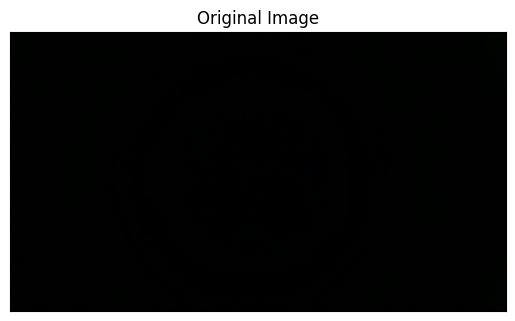

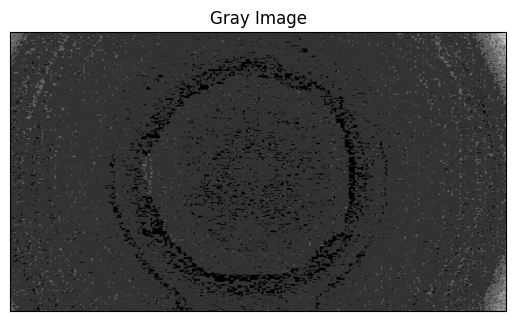

Faces found: 0


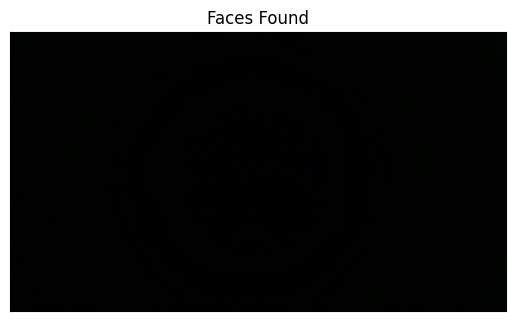

Access Denied
Denied Time: 2025-05-26 16:55:04
Security Breach


KeyboardInterrupt: 

In [1]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import pickle
import time
from pyfirmata import Arduino, util
from datetime import datetime

import firebase_admin
from firebase_admin import credentials, db

# Initialize Firebase Admin SDK
cred = credentials.Certificate("/Users/raulrazo/CS131-Final-Project/cs131-final-project-49b00-firebase-adminsdk-fbsvc-e557eaee88.json")
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://cs131-final-project-49b00-default-rtdb.firebaseio.com/'
})


DIGITAL_B = 11  # Blue LED
DIGITAL_G = 12  # Green LED
DIGITAL_R = 7   # Red LED
SERVO_PIN = 5
BUTTON_PIN = 10
WAIT_TIME = 2

flag = True

# === Setup Arduino ===
board = Arduino('/dev/tty.usbmodem1101')  # Replace with your port

# Start iterator for reading button input
it = util.Iterator(board)
it.start()
time.sleep(1)

# Setup pins
led_b = board.get_pin(f'd:{DIGITAL_B}:o')
led_g = board.get_pin(f'd:{DIGITAL_G}:o')
led_r = board.get_pin(f'd:{DIGITAL_R}:o')
servo = board.get_pin(f'd:{SERVO_PIN}:s')
button = board.get_pin(f'd:{BUTTON_PIN}:i')
button.enable_reporting()

# Initial LED state
led_b.write(1)
led_g.write(0)
led_r.write(0)


# === Take Picture with Webcam ===
camera = cv2.VideoCapture(0)
for i in range(3):
    success, img_captured = camera.read()
    time.sleep(0.3)
cv2.imwrite('capturedPicture.png', img_captured)
camera.release()

# === Load Models and Labels ===
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read("trainer.yml")

with open("labels.pickle", "rb") as pickleFile:
    original_labels = pickle.load(pickleFile)
    labels = {v: k for k, v in original_labels.items()}

# === Process Captured Image ===
imagePath = 'capturedPicture.png'
image = cv2.imread(imagePath)
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title("Original Image")
plt.imshow(image_RGB)
plt.xticks([]), plt.yticks([])
plt.show()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.title("Gray Image")
plt.imshow(gray, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.21,
    minNeighbors=4,
    minSize=(20, 20),
    flags=cv2.CASCADE_SCALE_IMAGE
)
print(f'Faces found: {len(faces)}')

# === Face Recognition ===
confidence = 0
for (x, y, w, h) in faces:
    cv2.rectangle(image_RGB, (x, y), (x+w, y+h), (0, 255, 0), 5)
    roi_gray = gray[y:y+h, x:x+w]
    id_now, confidence = recognizer.predict(roi_gray)
    print("confidence =", confidence)
    # print("Face Recognized")
    # print("Access Granted")

plt.title("Faces Found")
plt.imshow(image_RGB)
plt.xticks([]), plt.yticks([])
plt.show()

# === Access Control Logic ===
if confidence >= 10 and len(faces) > 0:
    print("Access Granted")
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print("Access Time:", timestamp)   
    print("Opening the secret exit")
    ref = db.reference("access_logs")
    ref.push({
        "status": "granted",
        "timestamp": timestamp,
        "person": labels.get(id_now, "Unknown")
    })
    led_b.write(0)
    while flag:
        led_g.write(1)
        servo.write(90)
        time.sleep(0.5)
        led_g.write(0)
        time.sleep(0.5)
        btn_value = button.read()
        if btn_value is True:  # button pressed
            print("System Reset")
            led_b.write(1)
            flag = False
            break
else:
    print("Access Denied")
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print("Denied Time:", timestamp) 
    print("Security Breach")
    ref = db.reference("access_logs")
    ref.push({
        "status": "denied",
        "timestamp": timestamp
    })
    led_b.write(0)
    while flag:
        led_r.write(1)
        time.sleep(0.5)
        led_r.write(0)
        time.sleep(0.5)
        btn_value = button.read()
        if btn_value is True:  # button pressed
            print("System Reset")
            led_b.write(1)
            flag = False
            break

board.exit()


In [97]:
camera = cv2.VideoCapture(0)

if not camera.isOpened():
    print("[ERROR] Could not open camera.")
    exit()
